# Environment

In [1]:
!pip install transformers
!pip install networkx
!pip install wordcloud

In [2]:
from google.colab import drive
from transformers import pipeline
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import pandas as pd
import networkx as nx
import re
import ast
import matplotlib.pyplot as plt
# plt.style.use('seaborn-v0_8')
plt.style.use('dark_background')

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Auxilary Methods

# Dataset Configuration

In [8]:
tweets = pd.read_csv('/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6414/Datasets/covid19_tweets.csv')
print(f'Original Dataset Shape: {tweets.shape}')
tweets.dropna(axis=0)
print(f'After dropping bad rows: {tweets.shape}')

Original Dataset Shape: (179108, 13)
After dropping bad rows: (179108, 13)


In [ ]:
print(f'Dataset Shape: {tweets.shape}')
print(f'Columns: {tweets.keys}')

Dataset Shape: (179108, 13)
Columns: <bound method NDFrame.keys of                      user_name               user_location  \
0                       ᏉᎥ☻լꂅϮ                  astroworld   
1                Tom Basile 🇺🇸                New York, NY   
2              Time4fisticuffs            Pewee Valley, KY   
3                  ethel mertz        Stuck in the Middle    
4                     DIPR-J&K           Jammu and Kashmir   
...                        ...                         ...   
179103  AJIMATI AbdulRahman O.             Ilorin, Nigeria   
179104                   Jason                     Ontario   
179105             BEEHEMOTH ⏳                   🇨🇦 Canada   
179106           Gary DelPonte               New York City   
179107                 TUKY II  Aliwal North, South Africa   

                                         user_description  \
0       wednesday addams as a disney princess keepin i...   
1       Husband, Father, Columnist & Commentator. Auth...   
2    

# Text Classification Model Configuration

In [ ]:
sentiment = pipeline(
    task='sentiment-analysis',
    model="cardiffnlp/twitter-roberta-base-sentiment-latest", #@param {type:"string"}
    device=0,
    batch_size=25000
)
"""
"LABEL_0" means that no misinformation was detected in the post
"LABEL_1" means that the post is misinformation.
"""
fake_news = pipeline(
    task='text-classification',
    model="spencer-gable-cook/COVID-19_Misinformation_Detector", #@param {type:"string"}
    device=0,
    batch_size=25000
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/348 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

# Dataset Augmentation

In [ ]:
tqdm.pandas()

In [ ]:
def convert_label_fn(x: str) -> str:
  adapter = {
      'LABEL_0': 'No Misinformation',
      'LABEL_1': 'Contains Misinformation'
  }
  return adapter[x]


In [ ]:
tweet_sentiment = tweets['text'].progress_apply(lambda x: sentiment(x)[0]['label'])
tweets['sentiment'] = tweet_sentiment

  0%|          | 11/179108 [00:02<7:31:30,  6.61it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 179108/179108 [33:50<00:00, 88.21it/s]


In [ ]:
tweets_misinformation = tweets['text'].progress_apply(lambda x: convert_label_fn(fake_news(x)[0]['label']))
tweets['validity'] = tweets_misinformation

  0%|          | 7/179108 [00:00<45:45, 65.22it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 179108/179108 [34:34<00:00, 86.32it/s]


In [ ]:
tweet_tags = tweets['text'].progress_apply(lambda x: str(re.findall('@\S+', x)))
tweets['tagged_users'] = tweet_tags

100%|██████████| 179108/179108 [00:00<00:00, 274864.05it/s]


In [ ]:
tweets['user_created'] = tweets['user_created'].progress_apply(lambda x: x[0:10])
tweets['date'] = tweets['date'].progress_apply(lambda x: x[0:10])

100%|██████████| 179108/179108 [00:00<00:00, 1029309.63it/s]


In [ ]:
tweets.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,sentiment,validity,tagged_users
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26,624,950,18775,False,2020-07-25,If I smelled the scent of hand sanitizers toda...,None,Twitter for iPhone,False,negative,No Misinformation,[]
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16,2253,1677,24,True,2020-07-25,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,None,Twitter for Android,False,neutral,No Misinformation,"['@Yankees', '@YankeesPR', '@MLB']"
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28,9275,9525,7254,False,2020-07-25,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,neutral,Contains Misinformation,"['@diane3443', '@wdunlap', '@realDonaldTrump']"
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07,197,987,1488,False,2020-07-25,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,positive,No Misinformation,['@brookbanktv']
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12,101009,168,101,False,2020-07-25,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,neutral,No Misinformation,"['@kansalrohit69', '@DrSyedSehrish', '@airnews..."


In [ ]:
tweets.to_parquet('/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6414/Datasets/UPDATED_covid19_tweets.parquet.gzip')

# Data Analytics

In [21]:
"""
I spent way too long trying to figure out why the CSV wasn't reading back properly...
It turns out that CSV being non-typed is a huge bummer :s
Parquet saves are much better
Never forget....
"""

# This is the base-case which evaluates the dataset on all rows
tweets = pd.read_parquet('/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6414/Datasets/UPDATED_covid19_tweets.parquet.gzip')
tweets = tweets.loc[tweets['validity'] == 'Contains Misinformation']
# tweets = tweets.loc[tweets['validity'] == 'No Misinformation']
tweets.dropna(axis=0)
tweets

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,sentiment,validity,tagged_users
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28,9275,9525,7254,False,2020-07-25,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,neutral,Contains Misinformation,"['@diane3443', '@wdunlap', '@realDonaldTrump']"
5,🎹 Franz Schubert,Новоро́ссия,🎼 #Новоро́ссия #Novorossiya #оставайсядома #S...,2018-03-19,1180,1071,1287,False,2020-07-25,#coronavirus #covid19 deaths continue to rise....,"['coronavirus', 'covid19']",Twitter Web App,False,negative,Contains Misinformation,[]
25,Blood Donors India,"Mumbai, India",Focused on matching blood donors with those in...,2008-12-23,1215920,2047,19359,True,2020-07-25,#Kolar\nNeed #Blood Type : B-positive\nAt : J...,"['Kolar', 'Blood', 'COVID19']",Blood Donors India,False,neutral,Contains Misinformation,[]
32,Beautify Data,"Miami, FL",We beautify data to learn and gain insight fro...,2019-02-18,82,92,1152,False,2020-07-25,"An update on the total #covid19 cases, recover...","['covid19', 'Africa']",Twitter Web App,False,neutral,Contains Misinformation,[]
43,TOI Delhi,"New Delhi, India",Your city. Your neighborhood. Your block. Cove...,2009-04-13,52186,41,74,True,2020-07-25,"#Delhi reports 1,142 #COVID19 positive cases a...","['Delhi', 'COVID19']",TweetDeck,False,negative,Contains Misinformation,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179089,Fzeroone,Lockdown will last for months,"""Always look on the bright side of death\njust...",2020-03-20,17,0,737,False,2020-08-29,@jridgway23 The world would be a better place ...,['Covid19'],Twitter Web App,False,negative,Contains Misinformation,['@jridgway23']
179091,🦋 ROGUE 🦋,None,May all aching hearts find their way there thr...,2017-01-30,628,386,14845,False,2020-08-29,"@dougmillsnyt @realDonaldTrump @FLOTUS ""The #T...",['Trump'],Twitter for Android,False,negative,Contains Misinformation,"['@dougmillsnyt', '@realDonaldTrump', '@FLOTUS']"
179094,Miriam van Gool,Utrecht,Biologist. Studying life on Earth. Sometimes l...,2009-01-18,979,1895,12761,False,2020-08-29,"""Symptom screening fails to identify most #Cov...",['Covid19'],Twitter Web App,False,negative,Contains Misinformation,[]
179097,rainmaker,None,None,2017-08-16,709,1158,95006,False,2020-08-29,@politvidchannel Just not the lives of #COVID1...,"['COVID19', 'coronavirus', 'TrumpVirus']",Twitter for Android,False,negative,Contains Misinformation,['@politvidchannel']


In [22]:
"""
Graph 1: User Interaction
  - Nodes represent twitter users
  - Edges represent @'s, thus we use a Digraph to encapsulate this relationship between users
"""
G = nx.DiGraph()
for index, row in tweets.iterrows():
  for tagged in ast.literal_eval(row['tagged_users']):
    G.add_edge(row['user_name'].strip(), tagged[1:].strip())

In [ ]:
nx.write_gexf(G, "/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6414/Fragments/covid19_tweets_misinformation_graph.gexf")

In [23]:
print(G)
print(f'Number of leaf nodes: {len([n for n in G.nodes() if G.out_degree(n)==0])}')
top_k_nodes = 10 #@param {type:"number"}
user_contrib =  sorted(G.degree, key=lambda x: x[1], reverse=True)[0:top_k_nodes]
plot_members = {}
print("Nodes with Largest Network Participation (Tweets, Tagged)")
for user in user_contrib:
  plot_members[user[0]] = user[1]
  print(user)

DiGraph with 14265 nodes and 13777 edges
Number of leaf nodes: 8527
Nodes with Largest Network Participation (Tweets, Tagged)
('realDonaldTrump', 848)
('GOP', 117)
('Malcolm Montgomery #WallOfVets', 108)
('Republic of New York', 95)
('POTUS', 92)
('TheCupofJoeintheD', 87)
('JoeBiden', 84)
('WhiteHouse', 69)
('WHO', 67)
('BorisJohnson', 64)


In [ ]:
# We will use Gephi to handle most of the graph-based analytics..

# Data Visualization

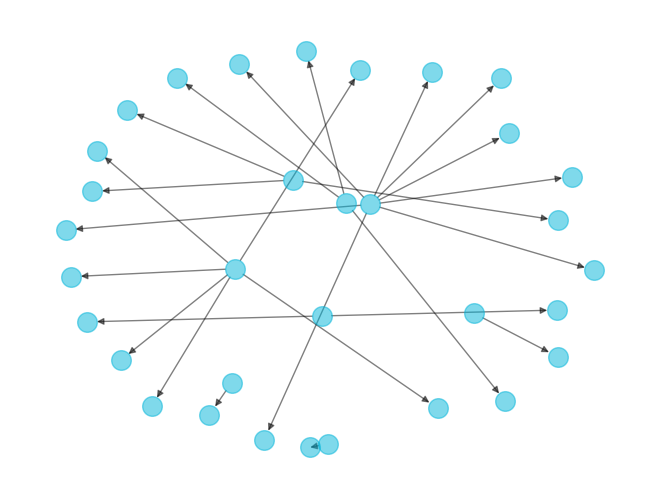

In [24]:
"""
Graph 1: User Interaction
  - Nodes represent twitter users
  - Edges represent @'s, thus we use a Digraph to encapsulate this relationship between users
"""
counter = 250 #@param {type:"number"}
G = nx.DiGraph()
for index, row in tweets.iterrows():
  if index < counter:
    for tagged in ast.literal_eval(row['tagged_users']):
      G.add_edge(row['user_name'], tagged)
      counter = counter + 1
  else:
    break
nx.draw(G,
        node_size=200,
        alpha=0.5,
        node_color='#00b4d9',
        with_labels=False
        )

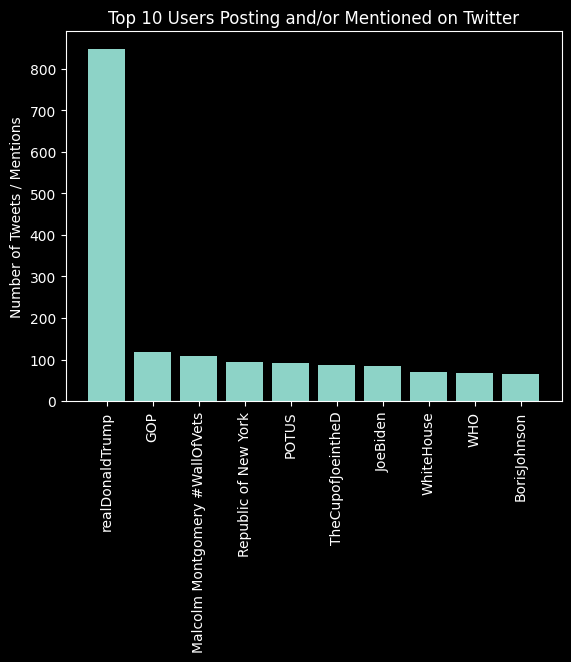

In [25]:
plt.title('Top {} Users Posting and/or Mentioned on Twitter'.format(top_k_nodes))
plt.xlabel=("Username (Tag)")
plt.ylabel("Number of Tweets / Mentions")
plt.bar(plot_members.keys(),
        plot_members.values(),
        label='Twitter Contribution',
        )
plt.xticks(rotation='vertical')
plt.autoscale()
plt.show()

In [26]:
hashtags = []
for entry in tweets['hashtags']:
  if str(entry).strip() != 'None':
    hashtags += ast.literal_eval(entry.lower())
  else:
    hashtags.append('none')
hashtag_count = Counter(hashtags)

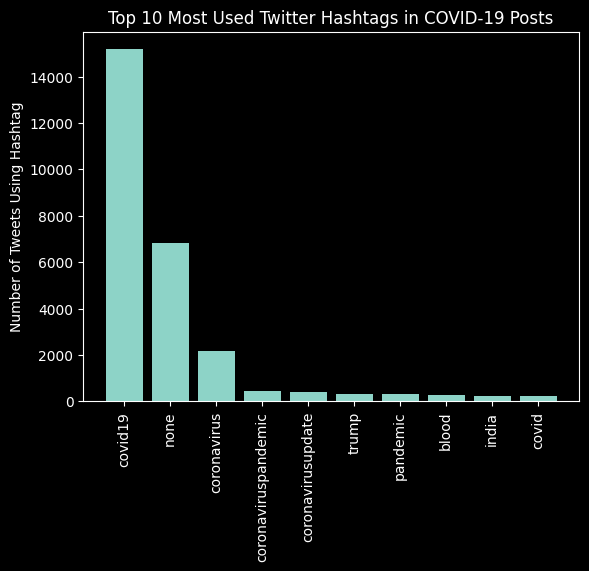

In [27]:
top_k_hashtags = 10 #@param{type:"integer"}
hashtags = hashtag_count.most_common(10)
plot_hashtags = {}
for entry in hashtags:
  plot_hashtags[entry[0]] = entry[1]

plt.title('Top {} Most Used Twitter Hashtags in COVID-19 Posts'.format(top_k_hashtags))
plt.xlabel=("Hashtags")
plt.ylabel("Number of Tweets Using Hashtag")
plt.bar(plot_hashtags.keys(),
        plot_hashtags.values(),
        label='Twitter Contribution',
        )
plt.xticks(rotation='vertical')
plt.autoscale()
plt.show()

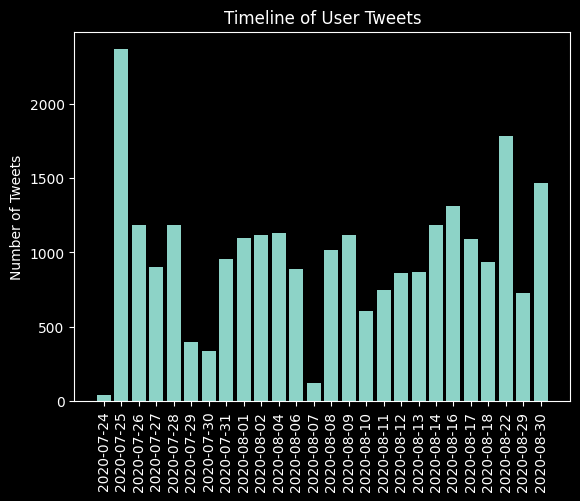

In [28]:
times = sorted(Counter(tweets['date']).most_common())
timeline = {}
for entry in times:
  timeline[entry[0]] = entry[1]
plt.title('Timeline of User Tweets')
plt.xlabel=("Date")
plt.ylabel("Number of Tweets")
plt.bar(timeline.keys(),
        timeline.values(),
        label='Tweets',
        )
plt.xticks(rotation='vertical')
plt.autoscale()
plt.show()

{'None': 6316, 'United States': 480, 'India': 455, 'Mumbai, India': 361, 'Earth': 254, 'New Delhi, India': 222, 'USA': 183, 'Washington, DC': 170, 'United Kingdom': 157, 'California, USA': 156}


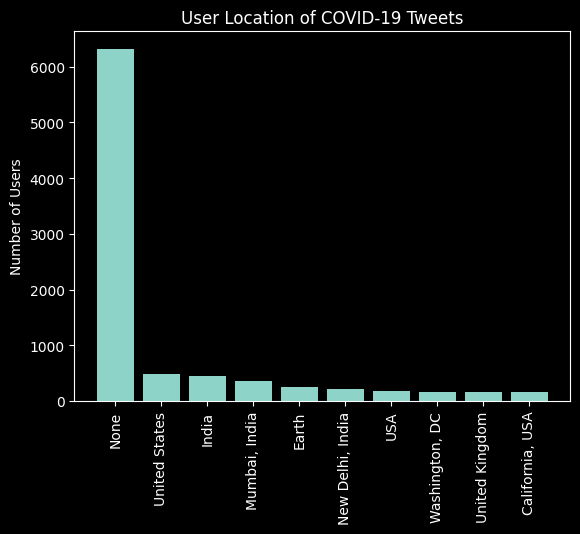

In [29]:
user_location = {}
for entry in Counter(tweets['user_location']).most_common(10):
  user_location[str(entry[0])] = entry[1]
print(user_location)
plt.title('User Location of COVID-19 Tweets')
plt.xlabel=("Location")
plt.ylabel("Number of Users")
plt.bar(user_location.keys(),
        user_location.values(),
        label='Tweets',
        )
plt.xticks(rotation='vertical')
plt.autoscale()
plt.show()


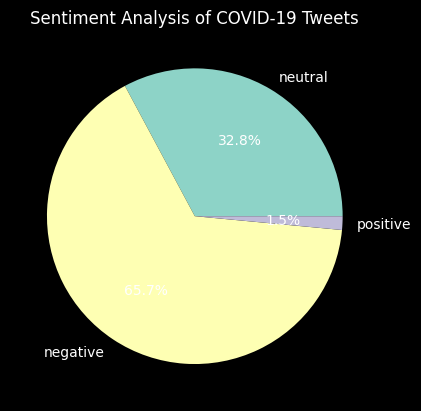

In [31]:
plt.title('Sentiment Analysis of COVID-19 Tweets'.format(top_k_nodes))
sentiment = Counter(tweets['sentiment'])
plt.pie(sentiment.values(), labels=sentiment.keys(), autopct='%1.1f%%')
plt.show()

Counter({'Contains Misinformation': 25462})


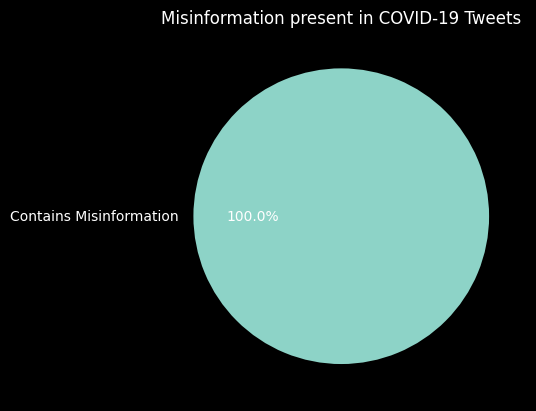

In [32]:
plt.title('Misinformation present in COVID-19 Tweets'.format(top_k_nodes))
validity = Counter(tweets['validity'])
plt.pie(validity.values(), labels=validity.keys(), autopct='%1.1f%%')
print(validity)
plt.show()

Counter({'Contains Misinformation': 25462})


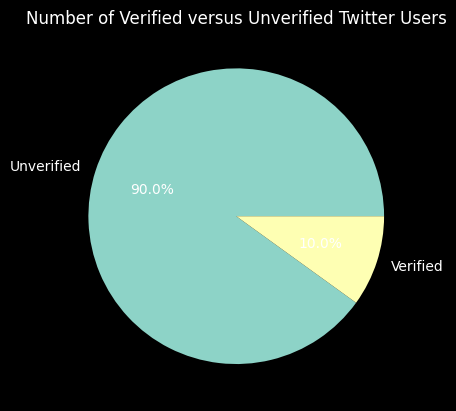

In [33]:
plt.title('Number of Verified versus Unverified Twitter Users')
user_types = Counter(tweets['user_verified'])
plt.pie(user_types.values(), labels=["Unverified", "Verified"], autopct='%1.1f%%')
print(validity)
plt.show()

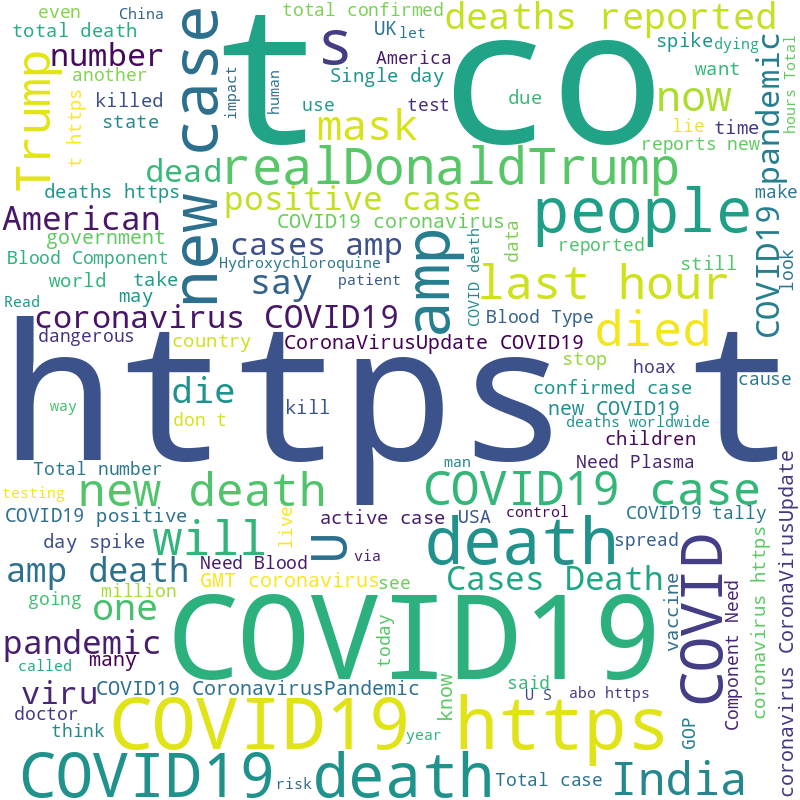

In [34]:
wv_all_tweets = WordCloud(
    background_color='white',
    width=800,
    height=800,
    stopwords=set(STOPWORDS),
    max_words=1000,
    min_font_size=12,
    random_state=2
)
wv_all_tweets.generate(' '.join(tweets['text']))
wv_all_tweets.to_image()

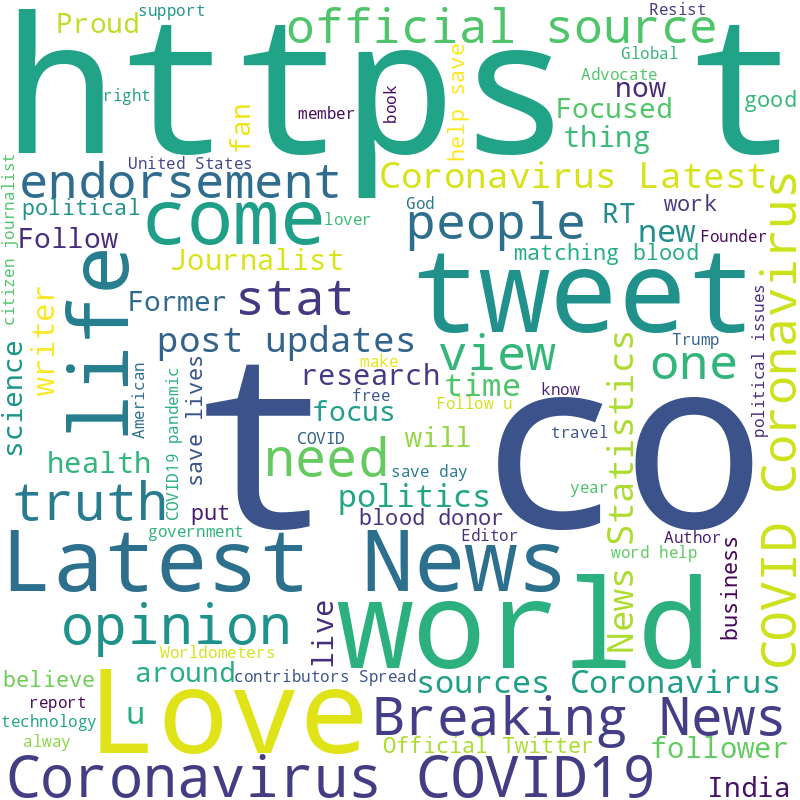

In [35]:
wv_all_tweets = WordCloud(
    background_color='white',
    width=800,
    height=800,
    stopwords=set(STOPWORDS),
    max_words=1000,
    min_font_size=12,
    random_state=2
)
wv_all_tweets.generate(' '.join(tweets['user_description'].dropna()))
wv_all_tweets.to_image()